# Binary Classification with a Bank Churn Dataset 2-2
## 1. ライブラリ

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

## 2. データの整理
### 2.1. データ取入れ

In [2]:
# Binary Classification with a Bank Churn Dataset のデータセット
dir_path = '/kaggle/input/playground-series-s4e1/'
test = pd.read_csv(dir_path + 'test.csv')       # テストデータ
train = pd.read_csv(dir_path + 'train.csv')     # 訓練データ
samp_sub = pd.read_csv(dir_path + 'sample_submission.csv')

# Bank Customer Churn Prediction のデータセット
original = pd.read_csv('/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv')
original = original.rename({'RowNumber':'id'}, axis = 1)    # 根源データ

### 2.2. originalの整理

In [3]:
original = original.drop(index=[4, 6, 8, 9, 9999, 10001])  # 欠損と重複データの削除
or_tr = pd.concat([train, original])    # 結合データ

### 2.3. 型変換

In [4]:
# 国データを整数データに変換するカテゴリ
Geography_cat = {'France'  : 0,
                 'Spain'   : 1,
                 'Germany' : 2}
# 性別データを整数データに変換するカテゴリ
Gender_cat = {'Female' : 0,
              'Male'   : 1}

# 全データの型変換
for data in [train, test, original, or_tr]:
    data.Geography = data.Geography.map(Geography_cat)
    data.Gender = data.Gender.map(Gender_cat)

### 2.4. 作成した特徴量

In [5]:
# CustomerIdの使用回数
# trainとtest
CI_used_t_cat = {}
for ci in set(train.CustomerId.unique()).union(set(test.CustomerId.unique())):
    # CustomerIdとその(trainとtest中の)使用回数を対応させるカテゴリ
    CI_used_t_cat[ci] = len(train[train.CustomerId==ci]) + len(test[test.CustomerId==ci])
for data in [train, test]:
    data['CI_used_t'] = data.CustomerId.map(CI_used_t_cat)

# or_trとtest
CI_used_ot_cat = {}
for ci in set(or_tr.CustomerId.unique()).union(set(test.CustomerId.unique())):
    # CustomerIdとその(or_trとtest中の)使用回数を対応させるカテゴリ
    CI_used_ot_cat[ci] = len(or_tr[or_tr.CustomerId==ci]) + len(test[test.CustomerId==ci])
for data in [or_tr, test]:
    data['CI_used_ot'] = data.CustomerId.map(CI_used_ot_cat)

    
# 各CustomerIdの口座解除率
# trainとtest
CI_rate_t_cat = {}
rate_t = train.Exited.sum()/len(train)
for ci in train.CustomerId.unique():
    # CustomerIdとその(train中の)口座解除確率を対応させる
    CI_rate_t_cat[ci] = (len(train[(train.CustomerId==ci)&(train.Exited==1)])+rate_t)/(len(train[train.CustomerId==ci])+1)
for ci in set(test.CustomerId.unique())-set(train.CustomerId.unique()):
    # trainにないCustomerIdをtrain全体の口座解除確率に対応させる
    CI_rate_t_cat[ci] = rate_t
for data in [train, test]:
    data['CI_rate_t'] = data.CustomerId.map(CI_rate_t_cat)
    
# or_trとtest
CI_rate_ot_cat = {}
rate_ot = or_tr.Exited.sum()/len(or_tr)
for ci in or_tr.CustomerId.unique():
    # CustomerIdとその(or_tr中の)口座解除確率を対応させる
    CI_rate_ot_cat[ci] = (len(or_tr[(or_tr.CustomerId==ci)&(or_tr.Exited==1)])+rate_ot)/(len(or_tr[or_tr.CustomerId==ci])+1)
for ci in set(test.CustomerId.unique())-set(or_tr.CustomerId.unique()):
    # or_trにないCustomerIdをor_tr全体の口座解除確率に対応させる
    CI_rate_ot_cat[ci] = rate_ot
for data in [or_tr, test]:
    data['CI_rate_ot'] = data.CustomerId.map(CI_rate_ot_cat)

### 2.5. スケーリング

In [6]:
for data in [train, test, original, or_tr]:
    data.CreditScore = (data.CreditScore-data.CreditScore.min())/(data.CreditScore.max()-data.CreditScore.min())
    data.Geography = data.Geography/2
    data.Age = data.Age/100
    data.Tenure = data.Tenure/10
    data.Balance = (data.Balance-data.Balance.min())/(data.Balance.max()-data.Balance.min())
    data.NumOfProducts = data.NumOfProducts/4
    data.EstimatedSalary = (data.EstimatedSalary-data.EstimatedSalary.min())/(data.EstimatedSalary.max()-data.EstimatedSalary.min())
    if 'CI_used_ot' in data.columns:
        data.CI_used_ot = data.CI_used_ot/200
    if 'CI_used_t' in data.columns:
        data.CI_used_t = data.CI_used_t/200

## 3. ランダムフォレストモデルの最適化
### 3.1. max_features, n_estimators

In [7]:
features_for_rfc = ['CreditScore', 'Geography', 'Age', 'Tenure', 'Balance',
                    'NumOfProducts', 'IsActiveMember', 'EstimatedSalary',
                    'CI_used_t', 'CI_rate_t']

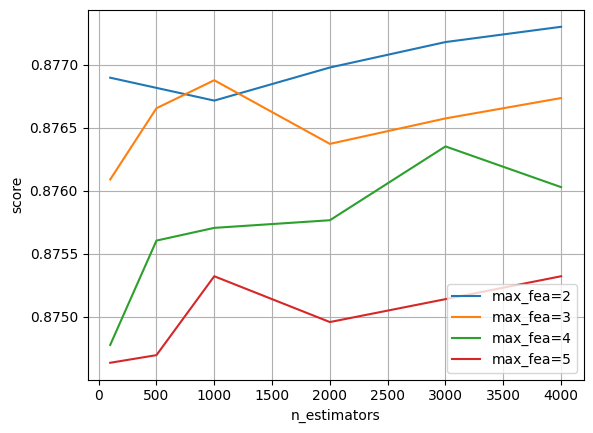

In [8]:
tra, val = train_test_split(train, test_size = 0.3)
max_features = [2, 3, 4, 5]
n_estimators = [100, 500, 1000, 2000, 3000, 4000]
scores = []
for m in max_features:
    scores.append([])
    for n in n_estimators:
        rfc = RandomForestClassifier(max_features=m, n_estimators=n, random_state = 0, n_jobs=-1)
        rfc.fit(tra[features_for_rfc], tra.Exited)
        scores[-1].append(rfc.score(val[features_for_rfc], val.Exited))
fig = plt.figure()
for i in range(len(max_features)):
    plt.plot(n_estimators, scores[i], label='max_fea='+str(max_features[i]))
plt.xlabel('n_estimators')
plt.ylabel('score')
plt.legend()
plt.grid()
plt.show()

### 3.2. criterion, max_depth

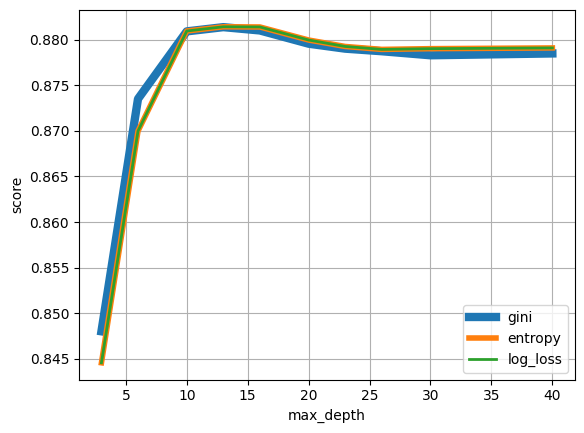

In [9]:
tra, val = train_test_split(train, test_size = 0.3)
criterion = ['gini', 'entropy', 'log_loss']
max_depth = [3, 6, 10, 13, 16, 20, 23, 26, 30, 40]
scores = []
for c in criterion:
    scores.append([])
    for m in max_depth:
        rfc = RandomForestClassifier(criterion=c, max_depth=m, max_features=3, n_estimators=3000, random_state = 0, n_jobs=-1)
        rfc.fit(tra[features_for_rfc], tra.Exited)
        scores[-1].append(rfc.score(val[features_for_rfc], val.Exited))
fig = plt.figure()
for i in range(3):
    plt.plot(max_depth, scores[i], lw=6-i*2, label=criterion[i])
plt.xlabel('max_depth')
plt.ylabel('score')
plt.legend()
plt.grid()
plt.show()

### 3.3. min_samples_leaf

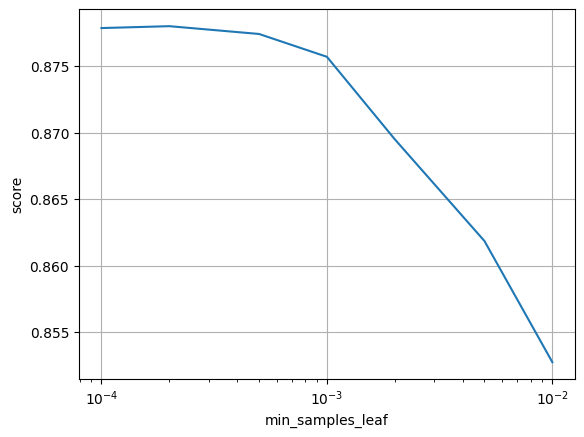

In [10]:
tra, val = train_test_split(train, test_size = 0.3)
min_samples_leaf = [0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01]
scores = []
for s in min_samples_leaf:
    rfc = RandomForestClassifier(min_samples_leaf=s, max_features=3, n_estimators=3000, random_state = 0, n_jobs=-1)
    rfc.fit(tra[features_for_rfc], tra.Exited)
    scores.append(rfc.score(val[features_for_rfc], val.Exited))
fig = plt.figure()
plt.plot(min_samples_leaf, scores)
plt.xlabel('min_samples_leaf')
plt.ylabel('score')
plt.xscale('log')
plt.grid()
plt.show()